# 5章 リカレントニューラルネットワーク（RNN）

In [2]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

corpus size: 1000, vocabulary size: 418
| epoch 1 | perplexity 344.80
| epoch 2 | perplexity 232.54
| epoch 3 | perplexity 215.20
| epoch 4 | perplexity 210.34
| epoch 5 | perplexity 202.47
| epoch 6 | perplexity 200.40
| epoch 7 | perplexity 196.44
| epoch 8 | perplexity 195.59
| epoch 9 | perplexity 190.95
| epoch 10 | perplexity 192.80
| epoch 11 | perplexity 188.70
| epoch 12 | perplexity 191.93
| epoch 13 | perplexity 189.78
| epoch 14 | perplexity 190.41
| epoch 15 | perplexity 188.01
| epoch 16 | perplexity 186.07
| epoch 17 | perplexity 183.70
| epoch 18 | perplexity 180.90
| epoch 19 | perplexity 181.41
| epoch 20 | perplexity 184.06
| epoch 21 | perplexity 182.07
| epoch 22 | perplexity 180.22
| epoch 23 | perplexity 178.17
| epoch 24 | perplexity 177.90
| epoch 25 | perplexity 176.18
| epoch 26 | perplexity 176.48
| epoch 27 | perplexity 169.77
| epoch 28 | perplexity 171.05
| epoch 29 | perplexity 170.00
| epoch 30 | perplexity 164.16
| epoch 31 | perplexity 165.19
| epoch 

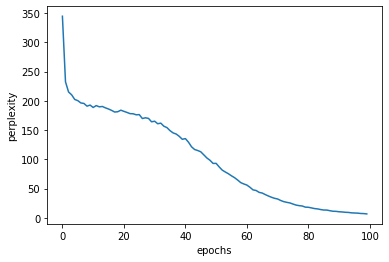

In [3]:
import matplotlib.pyplot as plt
from common.optimizer import SGD
from dataset import ptb

# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNNの隠れ状態ベクトルの要素数
time_size = 5  # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み（データセットを小さくする）
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f' % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# グラフの描画
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

| epoch 1 |  iter 1 / 19 | time 0[s] | perplexity 418.74
| epoch 2 |  iter 1 / 19 | time 0[s] | perplexity 389.81
| epoch 3 |  iter 1 / 19 | time 0[s] | perplexity 266.04
| epoch 4 |  iter 1 / 19 | time 0[s] | perplexity 221.56
| epoch 5 |  iter 1 / 19 | time 0[s] | perplexity 209.98
| epoch 6 |  iter 1 / 19 | time 0[s] | perplexity 208.68
| epoch 7 |  iter 1 / 19 | time 0[s] | perplexity 202.22
| epoch 8 |  iter 1 / 19 | time 0[s] | perplexity 201.24
| epoch 9 |  iter 1 / 19 | time 0[s] | perplexity 195.42
| epoch 10 |  iter 1 / 19 | time 0[s] | perplexity 191.89
| epoch 11 |  iter 1 / 19 | time 0[s] | perplexity 192.64
| epoch 12 |  iter 1 / 19 | time 0[s] | perplexity 190.47
| epoch 13 |  iter 1 / 19 | time 0[s] | perplexity 193.98
| epoch 14 |  iter 1 / 19 | time 0[s] | perplexity 187.98
| epoch 15 |  iter 1 / 19 | time 0[s] | perplexity 187.36
| epoch 16 |  iter 1 / 19 | time 0[s] | perplexity 191.18
| epoch 17 |  iter 1 / 19 | time 0[s] | perplexity 190.33
| epoch 18 |  iter 1 / 

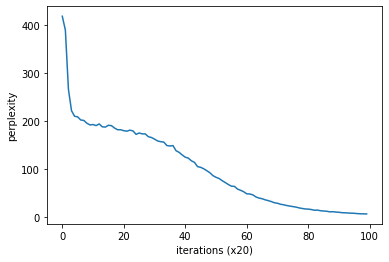

In [5]:
from common.trainer import RnnlmTrainer

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()